In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

In [2]:

class LabelGrid():
    """
    A class for label grid algorithm.
    
    The algorithm was proposed by Gröbe, M. and Burghardt, D., 2021. 
    Scale-Dependent Point Selection Methods for Web Maps. KN - Journal of 
    Cartography and Geographic Information.
    """
    
    def __init__(self, points, width, height, typ='square'):
        """
        Construct all the necessary attributes for the LabelGrid object.

        Parameters
        ----------
        points : GeoDataFrame
            GeoDataFrame of object points we want to apply the label grid algorithm.
        width : int
            Width of a cell.
        height : int
            Height of a cell.
        typ : str
            Form of a cell. The default is 'carre'.
        """
        self.__width = width
        self.__height = height
        self.__typ = typ
        self.__points = points
        self.__points_res = None
        self.__grid = None

    def __create_hexagonalCell(self, coords_min, coords_max):
        """
        Create a grid of hexagonal cells.

        Parameters
        ----------
        coords_min : tuple
            Coordinates of the bottom left cell first point.
        coords_max : tuple
            Coordinates of the top right cell last point.

        Returns
        -------
        polygons : GeoDataFrame
            Contains hexagonal polygon objects.
        """
        xstep = self.__width*3
        ystep = self.__width*2
        cols = list(np.arange(coords_min[0], coords_max[0]+xstep, xstep))
        rows = list(np.arange(coords_min[1], coords_max[1]+ystep, ystep))
        
        polygons = [Polygon([(x, y), 
                             (x + self.__width, y),
                             (x+self.__width*3/2, y+self.__width),
                             (x + self.__width, y+2*self.__width),
                             (x, y+2*self.__width),
                             (x-self.__width/2, y+self.__width)]) 
                    for x in cols[:-1] for y in rows[:-1]]
        return polygons

    def __createGrid(self):
        """
        Create the grid of the label grid.

        Returns
        -------
        GeoDataFrame
            Contains the grid polygons.

        """
        xmin, ymin, xmax, ymax = self.__points.total_bounds
        
        if self.__typ == 'square':
            cols = list(np.arange(xmin, xmax + self.__width, self.__width))
            rows = list(np.arange(ymin, ymax + self.__height, self.__height))
        
            polygons = [Polygon([(x, y), 
                                 (x + self.__width, y), 
                                 (x + self.__width, y + self.__height), 
                                 (x, y + self.__height)]) 
                        for x in cols[:-1] for y in rows[:-1]]
            
        if self.__typ == 'diamond':
            cols = list(np.arange(xmin, xmax + self.__width*2, self.__width))
            rows = list(np.arange(ymin-self.__width, ymax + self.__width, self.__width))
            
            polygons = [Polygon([(x, y), 
                                 (x + self.__width / 2, y + self.__width / 2), 
                                 (x, y + self.__width), 
                                 (x - self.__width / 2, y + self.__width / 2)]) 
                        for x in cols[:-1] for y in rows[:-1]]
            
        if self.__typ == 'hexagonal':

            odd_coords_min = (xmin-self.__width, ymin-self.__width)
            odd_coords_max = (xmax+self.__width, ymax)
            
            odd_poly = self.__create_hexagonalCell(odd_coords_min, odd_coords_max)
            
            not_odd_coords_min = (odd_coords_min[0]+3/2*self.__width, odd_coords_min[1]-self.__width)
            not_odd_coords_max = (odd_coords_max[0], odd_coords_max[1]+self.__width)
            
            not_odd_poly = self.__create_hexagonalCell(not_odd_coords_min, not_odd_coords_max)
            
            polygons = odd_poly + not_odd_poly
            
        return gpd.GeoDataFrame({'geometry':polygons})

    def set_point_label_grid(self):
        """Set the attributes points_res and grid of the LabelGrid object."""
        self.__points.reset_index(drop=True, inplace=True)
        self.__points = self.__points[['geometry', 'value']]
        
        self.__grid = self.__createGrid()
        
        lst_in_value = [self.__points.loc[cell.contains(self.__points['geometry']), 'value'] 
                        for cell in self.__grid['geometry']]

        lst_inter_value = [self.__points.loc[cell.touches(self.__points['geometry']), 'value'] 
                           for cell in self.__grid['geometry']]
        
        lst_all_value = [lst_inter_value[i] 
                         if lst_in_value[i].empty 
                         else pd.concat([lst_in_value[i],lst_inter_value[i]]) 
                         for i in range(len(lst_in_value))]
        
        ind = [e.nlargest(1).index[0] for e in lst_all_value if not e.empty]
        p = [self.__points['geometry'].iloc[i] for i in ind]
        
        point_results = gpd.GeoDataFrame(geometry=gpd.GeoSeries(p))
        self.__points_res = point_results

    def getPointResults(self):
        """Get points results."""
        return self.__points_res
    
    def getGrid(self):
        """Get the grid."""
        return self.__grid
    
    def draw(self):
        """Draw the grid with the points given and the grid with point results."""
        fig, ax1 = plt.subplots()
        self.__grid.boundary.plot(ax=ax1, color='goldenrod')
        self.__points.plot(ax=ax1, color='black')
        
        fig, ax2 = plt.subplots()
        self.__grid.boundary.plot(ax=ax2, color='goldenrod')
        self.__points_res.plot(ax=ax2, color='chocolate')

# Parameters

In [3]:
puntos = gpd.read_file('./data/puntos/puntos3.shp')
width = 10

# Create and set Label Grid object

In [4]:
lg = LabelGrid(puntos, width, width, "hexagonal")
lg.set_point_label_grid()

## Draw the result

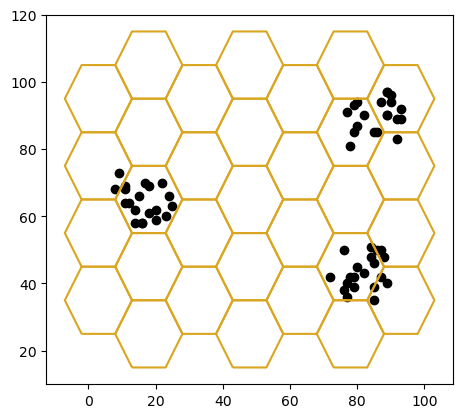

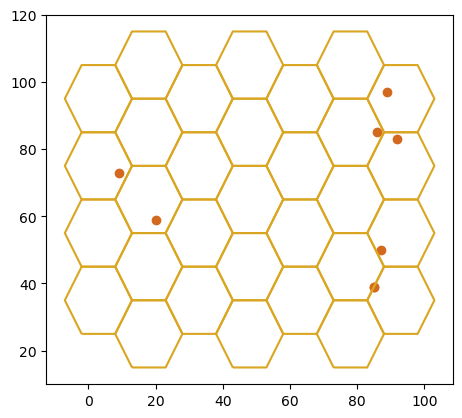

In [5]:
lg.draw()

### Square cells grid

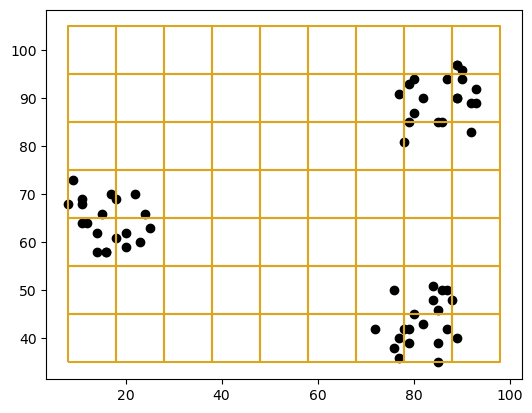

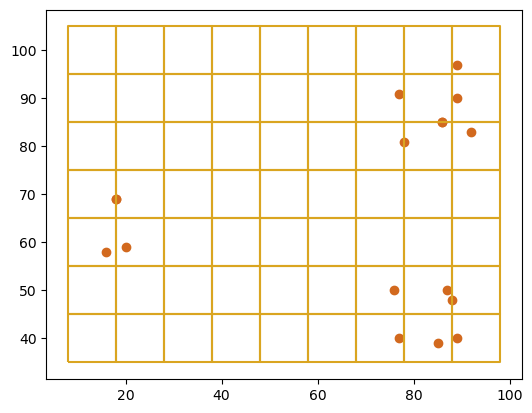

In [6]:
lg = LabelGrid(puntos, width, width, "square")
lg.set_point_label_grid()
lg.draw()

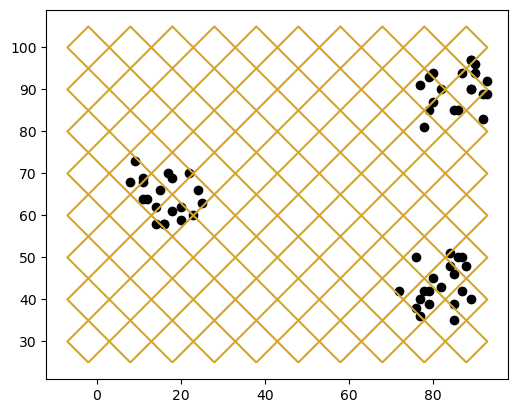

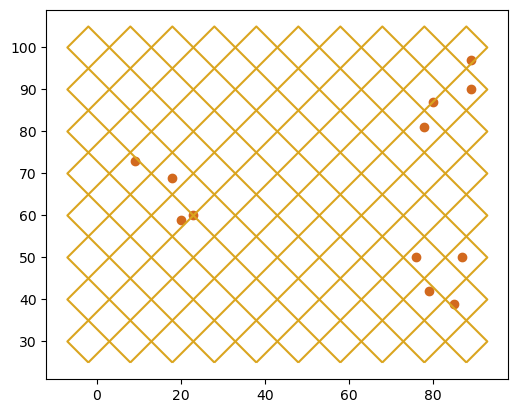

In [7]:
lg = LabelGrid(puntos, width, width, "diamond")
lg.set_point_label_grid()
lg.draw()